In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
13 * 5

65

In [3]:
import string

abcd = list(string.ascii_lowercase)

In [4]:
df_test = pd.read_csv(
    "../ProcessZ500/labels/df_labels_nocorrfilt_ERA5.csv", index_col=0, parse_dates=True
)
df_test = df_test["1948-01-01":"2023-12-31"]

df_test.loc[df_test["corr"] <= 0.2, "WR"] = np.unique(df_test["WR"])[-1]

# Read data

In [5]:
tx90p_diffs = xr.open_dataset(
    "../ProcessERA5_Surface/diffs_extremes/ds_extremes_tx90p_v2.nc"
)
ws_diffs = xr.open_dataset("../ProcessERA5_Surface/diffs_extremes/ds_extremes_ws_v2.nc")

# Extremely hot days

In [6]:
tx90_diff = xr.open_dataset('../ProcessERA5_Surface/diffs_data/tx90_diff_v2.nc')
arr = tx90_diff.difference_percent.values
arr[(tx90_diff.difference.values<=tx90_diff.q95.values)&(tx90_diff.difference.values>=tx90_diff.q05.values)] = np.nan
tx90_diff.difference_percent.data = arr

In [7]:
tx90_pt_diff = xr.open_dataset('../ProcessERA5_Surface/diffs_data/tx90_pt_diff_v2.nc')
tx90_pt_diff_bt2 = xr.open_dataset('../ProcessERA5_Surface/diffs_data/tx90_pt_diff_bt2_v2.nc')
arr = tx90_pt_diff.difference.values
arr[(arr<=tx90_pt_diff.q95.values)&(arr>=tx90_pt_diff.q05.values)] = np.nan
arr[(arr<=tx90_pt_diff_bt2.q95.values)&(arr>=tx90_pt_diff_bt2.q05.values)] = np.nan

tx90_pt_diff.difference.data = arr

In [8]:
tx90_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_tx90_anoms.nc')

# Extremely hot spells

In [9]:
ws_diff = xr.open_dataset('../ProcessERA5_Surface/diffs_data/ws_diff_v2.nc')
arr = ws_diff.difference_percent.values
arr[(ws_diff.difference.values<=ws_diff.q95.values)&(ws_diff.difference.values>=ws_diff.q05.values)] = np.nan
ws_diff.difference_percent.data = arr

In [10]:
ws_pt_diff = xr.open_dataset('../ProcessERA5_Surface/diffs_data/ws_pt_diff_v2.nc')
ws_pt_diff_bt2 = xr.open_dataset('../ProcessERA5_Surface/diffs_data/ws_pt_diff_bt2_v2.nc')
arr = ws_pt_diff.difference.values
arr[(arr<=ws_pt_diff.q95.values)&(arr>=ws_pt_diff.q05.values)] = np.nan
arr[(arr<=ws_pt_diff_bt2.q95.values)&(arr>=ws_pt_diff_bt2.q05.values)] = np.nan
ws_pt_diff.difference.data = arr

In [11]:
ws_corr = xr.open_dataset('../ProcessERA5_Surface/corr_data/corr_ws.nc')

# Plots

/glade/derecho/scratch/jhayron/tmp/ipykernel_62968/3764360009.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 4, 1, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_62968/3764360009.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 4, 2, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_62968/3764360009.py:99: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 4, 3, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_62968/3764360009.py:139: MatplotlibDeprecationWar

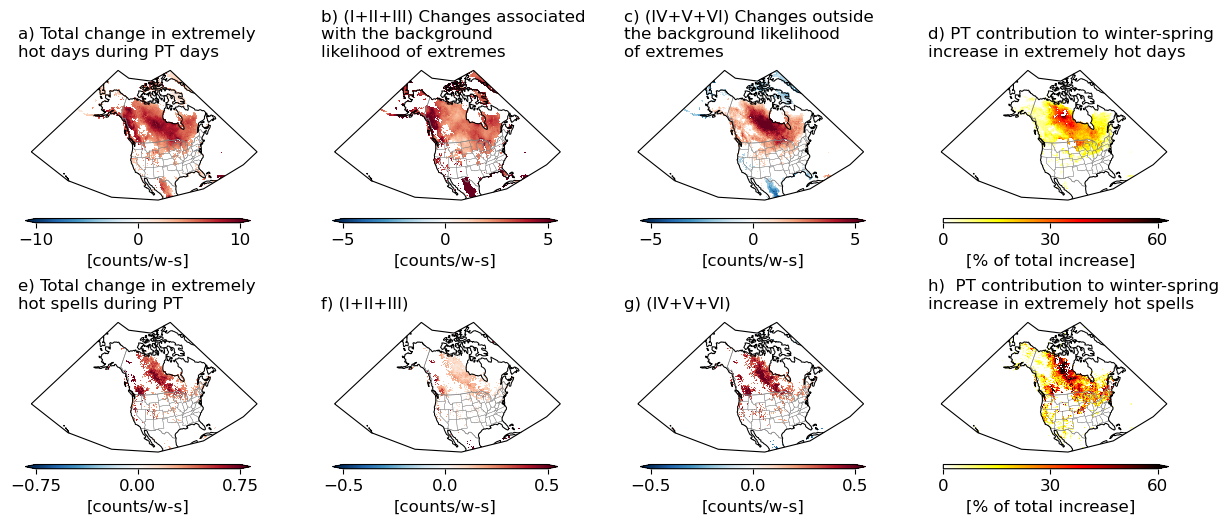

In [12]:
fontsize_most_things = 12

fig, axs = plt.subplots(
        2, 4,
        figsize=(15, 6))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]


# ################# PLOT Total increase in PT  ######################

ax = plt.subplot(2, 4, 1, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-10
maxi=10
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90_pt_diff.lon, 
        tx90_pt_diff.lat, 
        tx90_pt_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'a) Total change in extremely\nhot days during PT days', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.13, 0.57, 0.15, 0.007])
ticks_1 = [-10, 0, 10]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# ################# PLOT A1+A2+A3 (mean/nonPT increase per day) ######################

ax = plt.subplot(2, 4, 2, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-5
maxi=5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
quantity = (tx90p_diffs.a1+tx90p_diffs.a2+tx90p_diffs.a3).values
quantity[(np.isfinite(tx90_pt_diff.difference)==False).values] = np.nan
pm = ax.pcolormesh(tx90p_diffs.a1.lon, 
        tx90p_diffs.a1.lat, 
        quantity,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'b) (I+II+III) Changes associated\nwith the background\nlikelihood of extremes', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.335, 0.57, 0.15, 0.007])
ticks_1 = [-5, 0, 5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# # ################# A4+A5+A6 ######################

ax = plt.subplot(2, 4, 3, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-5
maxi=5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
quantity = (tx90p_diffs.a4+tx90p_diffs.a5+tx90p_diffs.a6).values
quantity[(np.isfinite(tx90_pt_diff.difference)==False).values] = np.nan
pm = ax.pcolormesh(tx90p_diffs.a1.lon, 
        tx90p_diffs.a1.lat, 
        quantity,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'c) (IV+V+VI) Changes outside\nthe background likelihood\nof extremes', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.54, 0.57, 0.15, 0.007])
ticks_1 = [-5, 0, 5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# # ################# PLOT PT contribution ######################

ax = plt.subplot(2, 4, 4, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=60
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90p_diffs.b_PT.lon, 
        tx90p_diffs.b_PT.lat, 
        (tx90p_diffs.a4+tx90p_diffs.a5+tx90p_diffs.a6)*100/tx90_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='hot_r')

ax.set_title(
    f"d) PT contribution to winter-spring\nincrease in extremely hot days",
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.742, 0.57, 0.15, 0.007])
ticks_1 = [0, 30,  60, 75]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='max')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[% of total increase]', fontsize=fontsize_most_things)



#  ################# PLOT WS diff PT ######################

ax = plt.subplot(2, 4, 5, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.75
maxi=0.75
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(ws_pt_diff.lon, 
        ws_pt_diff.lat, 
        ws_pt_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'e) Total change in extremely\nhot spells during PT', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.13, 0.16, 0.15, 0.007])
ticks_1 = [-0.75, 0, 0.75]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# # ################# PLOT A1+A2+A3 ######################

ax = plt.subplot(2, 4, 6, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.5
maxi=0.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
quantity = (ws_diffs.a1+ws_diffs.a2+ws_diffs.a3).values
quantity[(np.isfinite(ws_pt_diff.difference)==False).values] = np.nan
pm = ax.pcolormesh(ws_diffs.a1.lon, 
        ws_diffs.lat, 
        quantity,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'f) (I+II+III)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.335, 0.16, 0.15, 0.007])
ticks_1 = [-0.5, 0, 0.5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# # # # ################# WS A4+A5+A6 ######################

ax = plt.subplot(2, 4, 7, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.5
maxi=0.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
quantity = (ws_diffs.a4+ws_diffs.a5+ws_diffs.a6).values
quantity[(np.isfinite(ws_pt_diff.difference)==False).values] = np.nan
pm = ax.pcolormesh(ws_diffs.a1.lon, 
        ws_diffs.lat, 
        quantity,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'g) (IV+V+VI)', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.54, 0.16, 0.15, 0.007])
ticks_1 = [-0.5, 0, 0.5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# # ################# PLOT ws a2+a5 ######################

ax = plt.subplot(2, 4, 8, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=60
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90p_diffs.b_PT.lon, 
        tx90p_diffs.b_PT.lat, 
        (ws_diffs.a4+ws_diffs.a5+ws_diffs.a6)*100/ws_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='hot_r')

ax.set_title(
    f"h)  PT contribution to winter-spring\nincrease in extremely hot spells",
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.742, 0.16, 0.15, 0.007])
ticks_1 = [0, 30,  60, 75]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='max')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[% of total increase]', fontsize=fontsize_most_things)

plt.savefig('nFigures/5_Increase_Extremes.png',bbox_inches='tight')

In [13]:
panel_ptdiff = tx90_pt_diff.difference.values
panel_ptdiff[(np.isfinite(tx90_pt_diff.difference)==False).values] = np.nan

panel_contri = (tx90p_diffs.a4 + tx90p_diffs.a5 + tx90p_diffs.a6).values
panel_contri[(np.isfinite(tx90_pt_diff.difference)==False).values] = np.nan

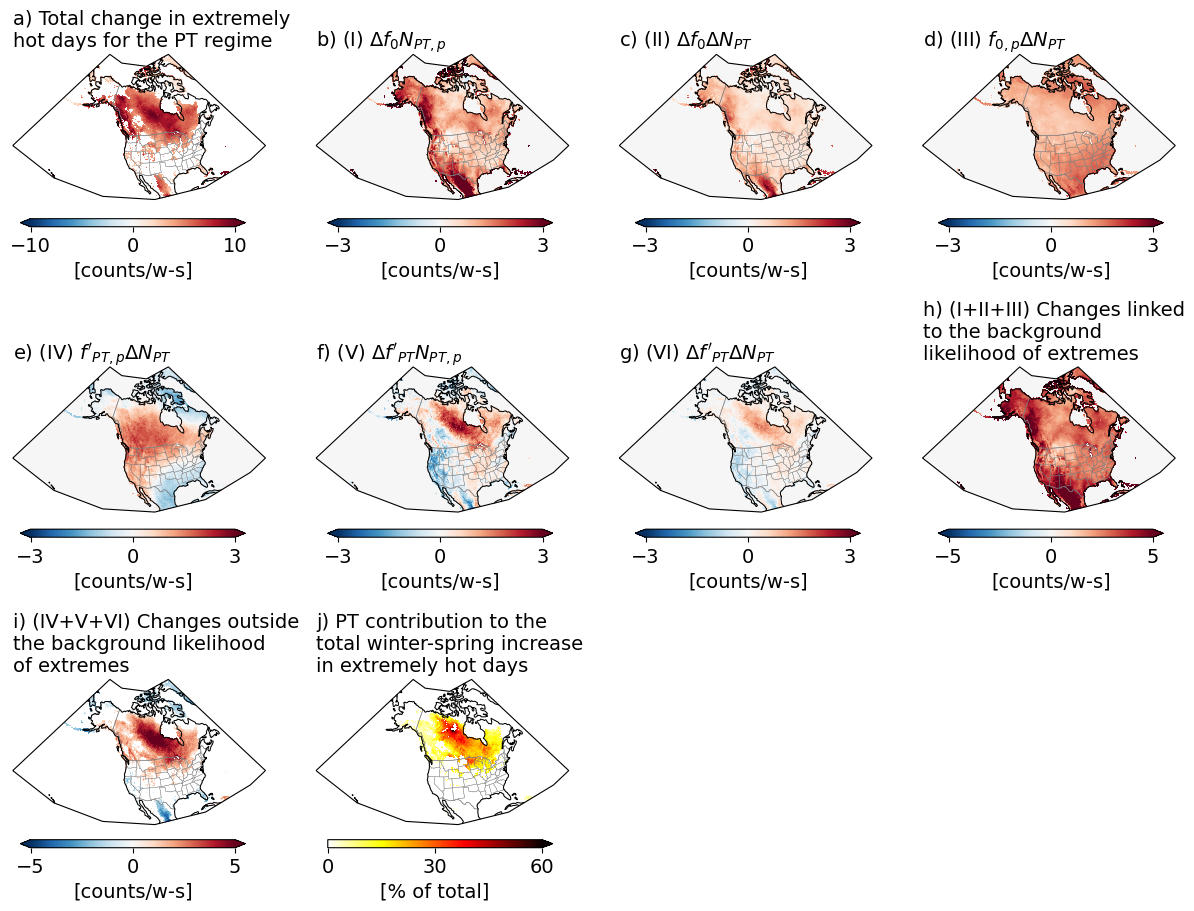

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

# --- Plotting Setup ---
fontsize_most_things = 14
fig, axs = plt.subplots(
    3, 4,
    figsize=(15, 11.5), # Adjusted figsize
    subplot_kw={'projection': ccrs.AlbersEqualArea(
        central_longitude=-115,
        central_latitude=50,
        standard_parallels=(30, 70)
    )}
)

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
verts = [
    (extent[0], extent[2]),  # Bottom-left
    (extent[1], extent[2]),  # Bottom-right
    (extent[1], extent[3]),  # Top-right
    (extent[0], extent[3]),  # Top-left
    (extent[0], extent[2])   # Close path
]
rect = mpath.Path(verts)

# --- Define a function for plotting to reduce code repetition ---
def plot_map(ax, data, lon, lat, title, cmap, vmin, vmax, cbar_pos, cbar_ticks, cbar_label, extend='both'):
    """Helper function to create a single map plot."""
    pm = ax.pcolormesh(lon, lat, data,
                       transform=ccrs.PlateCarree(),
                       vmin=vmin, vmax=vmax, cmap=cmap)

    ax.set_title(title, fontsize=fontsize_most_things, loc='left')
    ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)
    ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)
    ax.set_boundary(rect, transform=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Colorbar
    cbar_ax = fig.add_axes(cbar_pos)
    cbar = fig.colorbar(pm, cax=cbar_ax, ticks=cbar_ticks,
                        orientation='horizontal', extend=extend)
    cbar.ax.tick_params(labelsize=fontsize_most_things)
    cbar.set_label(cbar_label, fontsize=fontsize_most_things)
    return pm

# --- Plotting Dictionary ---
# We can store plot configurations in a dictionary to make the code cleaner
# Colorbar positions are updated to match the reference script
plot_configs = {
    'a': {'data': panel_ptdiff, 'title': 'a) Total change in extremely\nhot days for the PT regime', 'cmap': 'RdBu_r', 'vmin': -10, 'vmax': 10, 'cbar_pos': [0.13, 0.68, 0.15, 0.007], 'cbar_ticks': [-10, 0, 10], 'cbar_label': '[counts/w-s]'},
    'b': {'data': tx90p_diffs.a1, 'title': "b) (I) $\Delta f_0 N_{PT,p}}_{I}$", 'cmap': 'RdBu_r', 'vmin': -3, 'vmax': 3, 'cbar_pos': [0.335, 0.68, 0.15, 0.007], 'cbar_ticks': [-3, 0, 3], 'cbar_label': '[counts/w-s]'},
    'c': {'data': tx90p_diffs.a2, 'title': "c) (II) $\Delta f_0 \Delta N_{PT}$", 'cmap': 'RdBu_r', 'vmin': -3, 'vmax': 3, 'cbar_pos': [0.54, 0.68, 0.15, 0.007], 'cbar_ticks': [-3, 0, 3], 'cbar_label': '[counts/w-s]'},
    'd': {'data': tx90p_diffs.a3, 'title': "d) (III) $f_{0,p} \Delta N_{PT}$", 'cmap': 'RdBu_r', 'vmin': -3, 'vmax': 3, 'cbar_pos': [0.742, 0.68, 0.15, 0.007], 'cbar_ticks': [-3, 0, 3], 'cbar_label': '[counts/w-s]'},
    'e': {'data': tx90p_diffs.a4, 'title': "e) (IV) $f'_{PT,p} \Delta N_{PT}$", 'cmap': 'RdBu_r', 'vmin': -3, 'vmax': 3, 'cbar_pos': [0.13, 0.41, 0.15, 0.007], 'cbar_ticks': [-3, 0, 3], 'cbar_label': '[counts/w-s]'},
    'f': {'data': tx90p_diffs.a5, 'title': "f) (V) $\Delta f'_{PT} N_{PT,p}$", 'cmap': 'RdBu_r', 'vmin': -3, 'vmax': 3, 'cbar_pos': [0.335, 0.41, 0.15, 0.007], 'cbar_ticks': [-3, 0, 3], 'cbar_label': '[counts/w-s]'},
    'g': {'data': tx90p_diffs.a6, 'title': r"g) (VI) $\Delta f'_{PT} \Delta N_{PT}$", 'cmap': 'RdBu_r', 'vmin': -3, 'vmax': 3, 'cbar_pos': [0.54, 0.41, 0.15, 0.007], 'cbar_ticks': [-3, 0, 3], 'cbar_label': '[counts/w-s]'},
    'h': {'data': tx90p_diffs.a1 + tx90p_diffs.a2 + tx90p_diffs.a3, 'title': 'h) (I+II+III) Changes linked\nto the background\nlikelihood of extremes', 'cmap': 'RdBu_r', 'vmin': -5, 'vmax': 5, 'cbar_pos': [0.742, 0.41, 0.15, 0.007], 'cbar_ticks': [-5, 0, 5], 'cbar_label': '[counts/w-s]'},
    'i': {'data': panel_contri, 'title': 'i) (IV+V+VI) Changes outside\nthe background likelihood\nof extremes', 'cmap': 'RdBu_r', 'vmin': -5, 'vmax': 5, 'cbar_pos': [0.13, 0.14, 0.15, 0.007], 'cbar_ticks': [-5, 0, 5], 'cbar_label': '[counts/w-s]'},
    'j': {'data': (panel_contri) * 100 / tx90_diff.difference, 'title': 'j) PT contribution to the\ntotal winter-spring increase\nin extremely hot days', 'cmap': 'hot_r', 'vmin': 0, 'vmax': 60, 'cbar_pos': [0.335, 0.14, 0.15, 0.007], 'cbar_ticks': [0, 30, 60], 'cbar_label': '[% of total]', 'extend': 'max'},
}

# --- Generate Plots ---
for i, (key, config) in enumerate(plot_configs.items()):
    ax = axs_list[i]
    quantity = config['data'].copy() # Use copy to avoid modifying original dummy data

    plot_map(ax, quantity, tx90p_diffs.lon, tx90p_diffs.lat,
             config['title'], config['cmap'], config['vmin'], config['vmax'],
             config['cbar_pos'], config['cbar_ticks'], config['cbar_label'],
             extend=config.get('extend', 'both'))

# --- Clean up and Save ---
# Turn off the unused axes
for i in range(len(plot_configs), len(axs_list)):
    axs_list[i].set_visible(False)

# Using bbox_inches='tight' is often sufficient and more robust than manual adjustments
plt.savefig('nFigures/Increase_Extremes_HotDays.pdf',bbox_inches='tight')
# plt.show()

In [17]:
panel_ptdiff = ws_pt_diff.difference.values
panel_ptdiff[(np.isfinite(ws_pt_diff.difference)==False).values] = np.nan

panel_contri = (ws_diffs.a4 + ws_diffs.a5 + ws_diffs.a6).values
panel_contri[(np.isfinite(ws_pt_diff.difference)==False).values] = np.nan

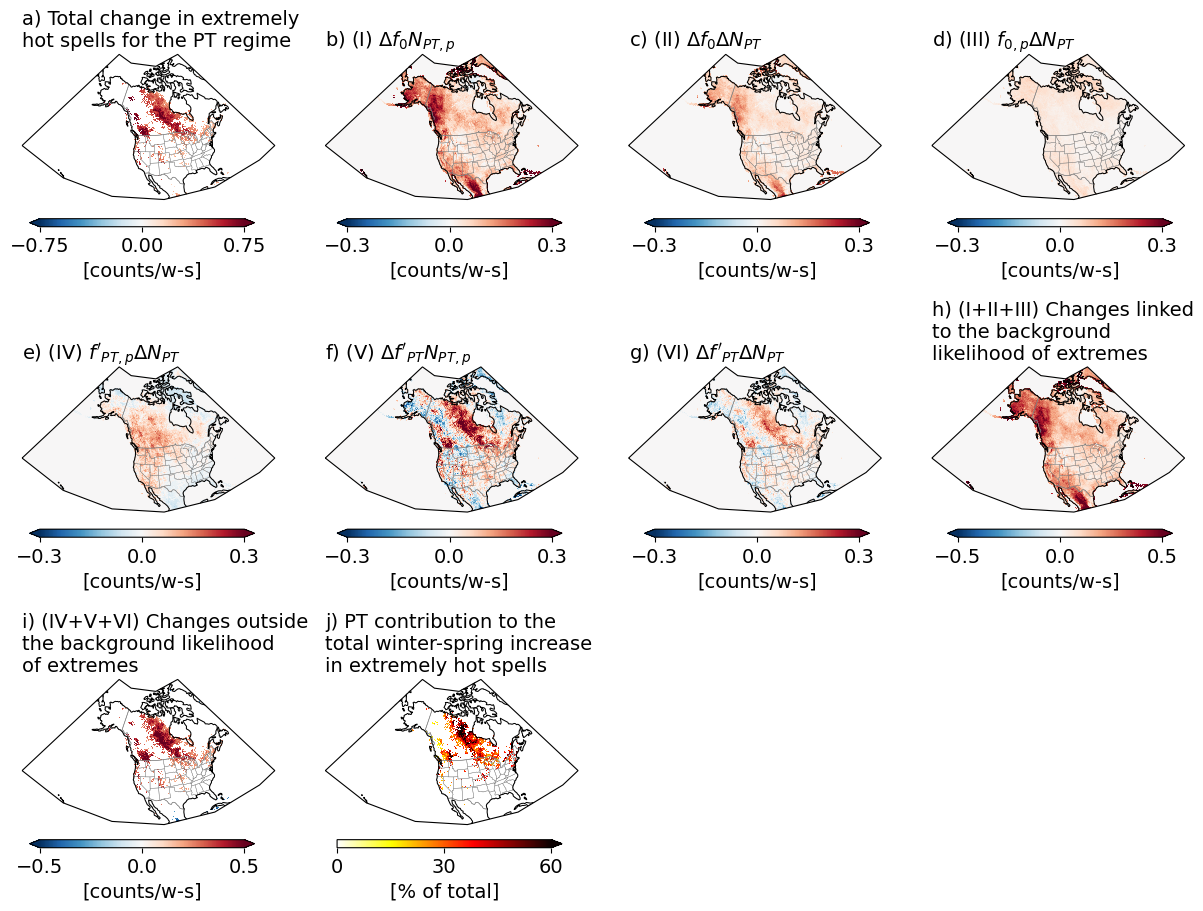

In [19]:
fontsize_most_things = 14
fig, axs = plt.subplots(
    3, 4,
    figsize=(15, 11.5), # Adjusted figsize
    subplot_kw={'projection': ccrs.AlbersEqualArea(
        central_longitude=-115,
        central_latitude=50,
        standard_parallels=(30, 70)
    )}
)

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
verts = [
    (extent[0], extent[2]),  # Bottom-left
    (extent[1], extent[2]),  # Bottom-right
    (extent[1], extent[3]),  # Top-right
    (extent[0], extent[3]),  # Top-left
    (extent[0], extent[2])   # Close path
]
rect = mpath.Path(verts)

# --- Define a function for plotting to reduce code repetition ---
def plot_map(ax, data, lon, lat, title, cmap, vmin, vmax, cbar_pos, cbar_ticks, cbar_label, extend='both'):
    """Helper function to create a single map plot."""
    pm = ax.pcolormesh(lon, lat, data,
                       transform=ccrs.PlateCarree(),
                       vmin=vmin, vmax=vmax, cmap=cmap)

    ax.set_title(title, fontsize=fontsize_most_things, loc='left')
    ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)
    ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)
    ax.set_boundary(rect, transform=ccrs.PlateCarree())
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Colorbar
    cbar_ax = fig.add_axes(cbar_pos)
    cbar = fig.colorbar(pm, cax=cbar_ax, ticks=cbar_ticks,
                        orientation='horizontal', extend=extend)
    cbar.ax.tick_params(labelsize=fontsize_most_things)
    cbar.set_label(cbar_label, fontsize=fontsize_most_things)
    return pm

# --- Plotting Dictionary for Hot Spells ---
# Variables and labels are updated for hot spells (ws)
# Vmin/vmax values are adjusted based on typical hot spell data ranges
plot_configs = {
    'a': {'data': panel_ptdiff, 'title': 'a) Total change in extremely\nhot spells for the PT regime', 'cmap': 'RdBu_r', 'vmin': -0.75, 'vmax': 0.75, 'cbar_pos': [0.13, 0.68, 0.15, 0.007], 'cbar_ticks': [-0.75, 0, 0.75], 'cbar_label': '[counts/w-s]'},
    'b': {'data': ws_diffs.a1, 'title': "b) (I) $\Delta f_0 N_{PT,p}}_{I}$", 'cmap': 'RdBu_r', 'vmin': -0.3, 'vmax': 0.3, 'cbar_pos': [0.335, 0.68, 0.15, 0.007], 'cbar_ticks': [-0.3, 0, 0.3], 'cbar_label': '[counts/w-s]'},
    'c': {'data': ws_diffs.a2, 'title': "c) (II) $\Delta f_0 \Delta N_{PT}$", 'cmap': 'RdBu_r', 'vmin': -0.3, 'vmax': 0.3, 'cbar_pos': [0.54, 0.68, 0.15, 0.007], 'cbar_ticks': [-0.3, 0, 0.3], 'cbar_label': '[counts/w-s]'},
    'd': {'data': ws_diffs.a3, 'title': "d) (III) $f_{0,p} \Delta N_{PT}$", 'cmap': 'RdBu_r', 'vmin': -0.3, 'vmax': 0.3, 'cbar_pos': [0.742, 0.68, 0.15, 0.007], 'cbar_ticks': [-0.3, 0, 0.3], 'cbar_label': '[counts/w-s]'},
    'e': {'data': ws_diffs.a4, 'title': "e) (IV) $f'_{PT,p} \Delta N_{PT}$", 'cmap': 'RdBu_r', 'vmin': -0.3, 'vmax': 0.3, 'cbar_pos': [0.13, 0.41, 0.15, 0.007], 'cbar_ticks': [-0.3, 0, 0.3], 'cbar_label': '[counts/w-s]'},
    'f': {'data': ws_diffs.a5, 'title': "f) (V) $\Delta f'_{PT} N_{PT,p}$", 'cmap': 'RdBu_r', 'vmin': -0.3, 'vmax': 0.3, 'cbar_pos': [0.335, 0.41, 0.15, 0.007], 'cbar_ticks': [-0.3, 0, 0.3], 'cbar_label': '[counts/w-s]'},
    'g': {'data': ws_diffs.a6, 'title': r"g) (VI) $\Delta f'_{PT} \Delta N_{PT}$", 'cmap': 'RdBu_r', 'vmin': -0.3, 'vmax': 0.3, 'cbar_pos': [0.54, 0.41, 0.15, 0.007], 'cbar_ticks': [-0.3, 0, 0.3], 'cbar_label': '[counts/w-s]'},
    'h': {'data': ws_diffs.a1 + ws_diffs.a2 + ws_diffs.a3, 'title': 'h) (I+II+III) Changes linked\nto the background\nlikelihood of extremes', 'cmap': 'RdBu_r', 'vmin': -0.5, 'vmax': 0.5, 'cbar_pos': [0.742, 0.41, 0.15, 0.007], 'cbar_ticks': [-0.5, 0, 0.5], 'cbar_label': '[counts/w-s]'},
    'i': {'data': panel_contri, 'title': 'i) (IV+V+VI) Changes outside\nthe background likelihood\nof extremes', 'cmap': 'RdBu_r', 'vmin': -0.5, 'vmax': 0.5, 'cbar_pos': [0.13, 0.14, 0.15, 0.007], 'cbar_ticks': [-0.5, 0, 0.5], 'cbar_label': '[counts/w-s]'},
    'j': {'data': (panel_contri) * 100 / ws_diff.difference, 'title': 'j) PT contribution to the\ntotal winter-spring increase\nin extremely hot spells', 'cmap': 'hot_r', 'vmin': 0, 'vmax': 60, 'cbar_pos': [0.335, 0.14, 0.15, 0.007], 'cbar_ticks': [0, 30, 60], 'cbar_label': '[% of total]', 'extend': 'max'},
}

# --- Generate Plots ---
for i, (key, config) in enumerate(plot_configs.items()):
    ax = axs_list[i]
    # Make sure you load your actual data here. The .copy() is for the dummy data.
    quantity = config['data'].copy() 

    plot_map(ax, quantity, ws_diffs.lon, ws_diffs.lat,
             config['title'], config['cmap'], config['vmin'], config['vmax'],
             config['cbar_pos'], config['cbar_ticks'], config['cbar_label'],
             extend=config.get('extend', 'both'))

# --- Clean up and Save ---
# Turn off the unused axes
for i in range(len(plot_configs), len(axs_list)):
    axs_list[i].set_visible(False)

# Using bbox_inches='tight' is often sufficient and more robust than manual adjustments
plt.savefig('nFigures/Increase_Extremes_HotSpells.pdf',bbox_inches='tight')

/glade/derecho/scratch/jhayron/tmp/ipykernel_43981/96182479.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 4, 1, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_43981/96182479.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 4, 2, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_43981/96182479.py:99: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 4, 3, projection=ccrs.AlbersEqualArea(
/glade/derecho/scratch/jhayron/tmp/ipykernel_43981/96182479.py:139: MatplotlibDeprecationWarning: Au

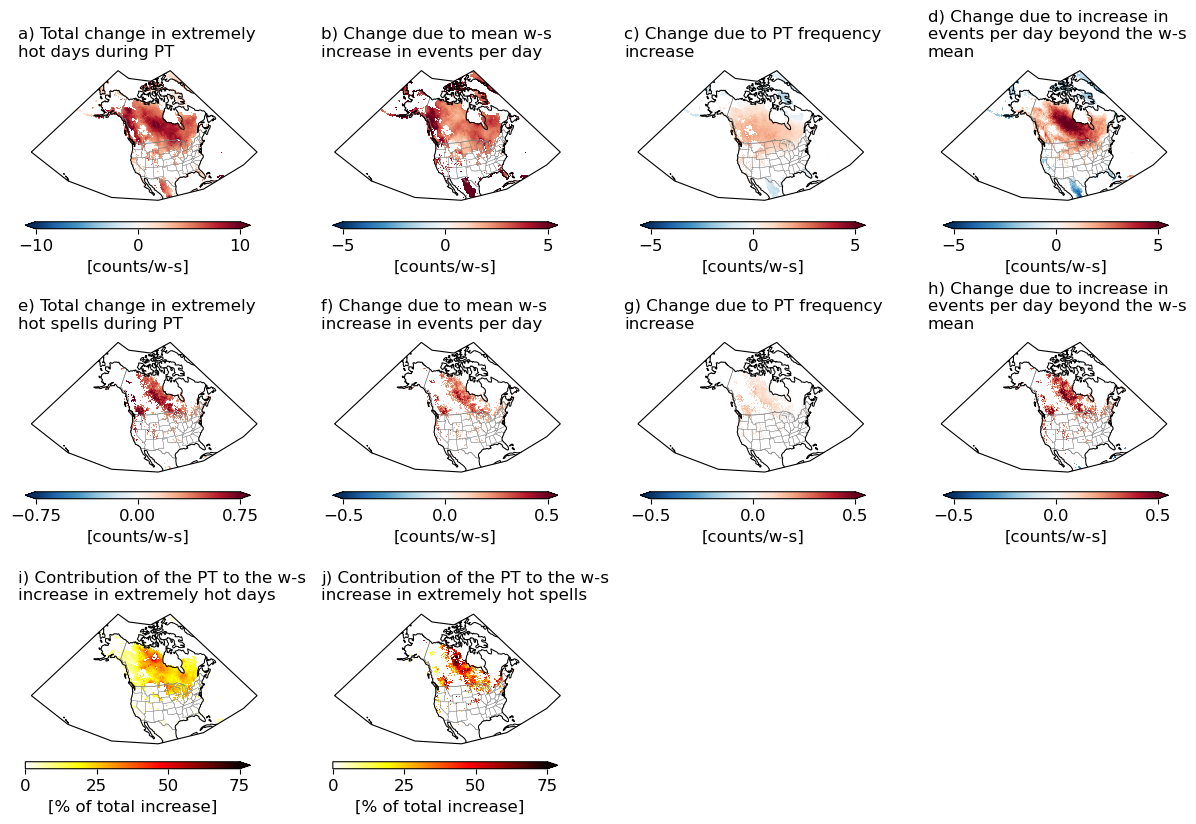

In [23]:
fontsize_most_things = 12

fig, axs = plt.subplots(
        3, 4,
        figsize=(15, 10))

axs_list = axs.flatten().tolist()
extent = [-180, -50, 20, 80]
# Create a rectangular boundary matching the extent
verts = [
    (extent[0], extent[2]),  # Bottom-left corner
    (extent[1], extent[2]),  # Bottom-right corner
    (extent[1], extent[3]),  # Top-right corner
    (extent[0], extent[3]),  # Top-left corner
    (extent[0], extent[2])   # Closing the rectangle
]


# ################# PLOT Total increase in PT  ######################

ax = plt.subplot(3, 4, 1, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-10
maxi=10
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90_pt_diff.lon, 
        tx90_pt_diff.lat, 
        tx90_pt_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'a) Total change in extremely\nhot days during PT', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.13, 0.68, 0.15, 0.007])
ticks_1 = [-10, 0, 10]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# ################# PLOT A1+A2+A3 (mean/nonPT increase per day) ######################

ax = plt.subplot(3, 4, 2, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-5
maxi=5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
quantity = (tx90p_diffs.a1+tx90p_diffs.a2+tx90p_diffs.a3).values
quantity[(np.isfinite(tx90_pt_diff.difference)==False).values] = np.nan
pm = ax.pcolormesh(tx90p_diffs.a1.lon, 
        tx90p_diffs.a1.lat, 
        quantity,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'b) Change due to mean w-s\nincrease in events per day', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.335, 0.68, 0.15, 0.007])
ticks_1 = [-5, 0, 5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# # ################# Increase just due to increase in frequency ######################

ax = plt.subplot(3, 4, 3, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-5
maxi=5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
quantity = (tx90p_diffs.a4).values
quantity[(np.isfinite(tx90_pt_diff.difference)==False).values] = np.nan
pm = ax.pcolormesh(tx90p_diffs.a1.lon, 
        tx90p_diffs.a1.lat, 
        quantity,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'c) Change due to PT frequency\nincrease', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.54, 0.68, 0.15, 0.007])
ticks_1 = [-5, 0, 5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# # ################# PLOT A2+A5 ######################

ax = plt.subplot(3, 4, 4, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-5
maxi=5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
quantity = (tx90p_diffs.a4+tx90p_diffs.a5+tx90p_diffs.a6).values
quantity[(np.isfinite(tx90_pt_diff.difference)==False).values] = np.nan
pm = ax.pcolormesh(tx90p_diffs.a1.lon, 
        tx90p_diffs.a1.lat, 
        quantity,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'd) Change due to increase in\nevents per day beyond the w-s\nmean', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.742, 0.68, 0.15, 0.007])
ticks_1 = [-5, 0, 5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

#  ################# PLOT WS diff PT ######################

ax = plt.subplot(3, 4, 5, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.75
maxi=0.75
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(ws_pt_diff.lon, 
        ws_pt_diff.lat, 
        ws_pt_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'e) Total change in extremely\nhot spells during PT', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.13, 0.41, 0.15, 0.007])
ticks_1 = [-0.75, 0, 0.75]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# # ################# PLOT A1+A4 ######################

ax = plt.subplot(3, 4, 6, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.5
maxi=0.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
quantity = (ws_diffs.a2+ws_diffs.a4).values
quantity[(np.isfinite(ws_pt_diff.difference)==False).values] = np.nan
pm = ax.pcolormesh(ws_diffs.a1.lon, 
        ws_diffs.lat, 
        quantity,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'f) Change due to mean w-s\nincrease in events per day', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.335, 0.41, 0.15, 0.007])
ticks_1 = [-0.5, 0, 0.5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# # # ################# WS A3 ######################

ax = plt.subplot(3, 4, 7, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.5
maxi=0.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
quantity = (ws_diffs.a3).values
quantity[(np.isfinite(ws_pt_diff.difference)==False).values] = np.nan
pm = ax.pcolormesh(ws_diffs.a1.lon, 
        ws_diffs.lat, 
        quantity,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'g) Change due to PT frequency\nincrease', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.54, 0.41, 0.15, 0.007])
ticks_1 = [-0.5, 0, 0.5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# # ################# PLOT ws a2+a5 ######################

ax = plt.subplot(3, 4, 8, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=-0.5
maxi=0.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
quantity = (ws_diffs.a2+ws_diffs.a5).values
quantity[(np.isfinite(ws_pt_diff.difference)==False).values] = np.nan
pm = ax.pcolormesh(ws_diffs.a1.lon, 
        ws_diffs.lat, 
        quantity,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='RdBu_r')

ax.set_title(
    f'h) Change due to increase in\nevents per day beyond the w-s\nmean', 
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.742, 0.41, 0.15, 0.007])
ticks_1 = [-0.5, 0, 0.5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[counts/w-s]', fontsize=fontsize_most_things)

# ################# PLOT extremely hot days corr ######################

ax = plt.subplot(3, 4, 9, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=75
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90p_diffs.b_PT.lon, 
        tx90p_diffs.b_PT.lat, 
        (tx90p_diffs.a3+tx90p_diffs.a4+tx90p_diffs.a5)*100/tx90_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='hot_r')

ax.set_title(
    f"i) Contribution of the PT to the w-s\nincrease in extremely hot days",
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.13, 0.14, 0.15, 0.007])
ticks_1 = [0, 25,  50, 75]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='max')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[% of total increase]', fontsize=fontsize_most_things)

# ################# PLOT warm spells PT corr ######################

ax = plt.subplot(3, 4, 10, projection=ccrs.AlbersEqualArea(
            central_longitude=-115,
            central_latitude=50,
            standard_parallels=(30, 70)
        ))

mini=0
maxi=75
intervals = 41
bounds=np.linspace(mini,maxi,intervals)
pm = ax.pcolormesh(tx90p_diffs.b_PT.lon, 
        tx90p_diffs.b_PT.lat, 
        (ws_diffs.a2+ws_diffs.a3+ws_diffs.a5)*100/ws_diff.difference,
        transform=ccrs.PlateCarree(),
        vmin=mini, vmax=maxi, cmap='hot_r')

ax.set_title(
    f"j) Contribution of the PT to the w-s\nincrease in extremely hot spells",
    fontsize=fontsize_most_things,loc='left')

ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.margins(x=0, y=0)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

rect = mpath.Path(verts)
# Set the boundary of the plot
ax.set_boundary(rect, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.335, 0.14, 0.15, 0.007])
ticks_1 = [0, 25,  50, 75]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='max')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[% of total increase]', fontsize=fontsize_most_things)

fig.delaxes(axs[2, 2])  # This deletes the bottom-right subplot (2nd row, 4th column)
fig.delaxes(axs[2, 3])  # This deletes the bottom-right subplot (2nd row, 4th column)
# plt.savefig('nFigures/5_Increase_Extremes.pdf',bbox_inches='tight')